In [1]:
import pymc4 as pm
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
config = tf.ConfigProto()
config.graph_options.optimizer_options.global_jit_level = (
    tf.OptimizerOptions.ON_1)
config.intra_op_parallelism_threads = 1
config.inter_op_parallelism_threads = 1
sess = tf.InteractiveSession(config=config)

# Linear Regression

In [3]:
# Logp calculation for linear regression 
@pm.model
def linreg(sd_prior='half_normal', n_points = 100):    
    # Define priors
    sigma = pm.HalfNormal('sigma', scale = 10)
    intercept = pm.Normal('Intercept', 0, scale=10)
    x_coeff = pm.Normal('weight', 0, scale = 5)
    x = np.linspace(-5, 5, n_points)
    
    # Define likelihood
    y = pm.Normal('y', loc=intercept + x_coeff * x, scale=sigma)
    
    
model = linreg.configure()

forward_sample = sess.run(model.forward_sample())

forward_sample

{'sigma': 4.258111,
 'Intercept': 9.655149,
 'weight': 3.1631496,
 'y': array([-5.5167084 , -7.952612  , -1.5601134 , -1.2874141 ,  0.32460308,
        -4.3157973 ,  0.33471632, -4.4301014 , -7.1566343 , -4.940994  ,
        -0.25612712, -1.5415602 ,  2.7236    , -3.8509178 ,  0.5439651 ,
        -6.865728  ,  2.6331136 , -0.72919506,  1.5297073 ,  3.21514   ,
        -1.5934671 ,  5.944141  ,  3.0594277 ,  1.2120215 ,  1.5937328 ,
         4.23386   ,  6.8364124 , -1.922761  ,  1.2717962 ,  2.2777555 ,
         5.545568  , 10.827419  , -3.3906841 , 10.942558  ,  7.6665792 ,
        -0.26901007,  4.8275046 ,  5.2839794 , 12.964446  , 18.133781  ,
        14.699654  , 13.105689  ,  7.8113303 , 10.807865  , 11.2816515 ,
        15.297579  ,  0.22558022,  6.010298  ,  9.403929  ,  9.95819   ,
         2.5106149 ,  7.4283485 , 13.703525  ,  5.8163853 ,  7.452306  ,
        14.363668  , 13.058856  , 18.942518  , 10.040317  ,  8.453892  ,
         9.463808  , 15.683676  ,  8.485954  , 14.019

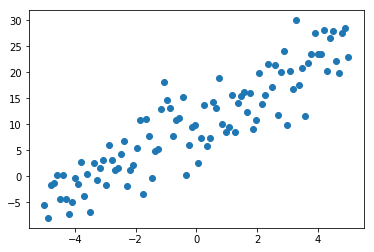

In [4]:
plt.scatter(np.linspace(-5, 5, 100), forward_sample['y'])

In [5]:
func = model.make_log_prob_function()
sigma = tf.placeholder(tf.float32)
intercept = tf.placeholder(tf.float32)
x_coeff = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32, shape=(100,))
logp = func(sigma, intercept, x_coeff, y)


In [6]:
feed_dict = {sigma: forward_sample['sigma'], 
            intercept: forward_sample['Intercept'], 
            x_coeff: forward_sample['weight'], 
            y: forward_sample['y']}

sess.run(logp, feed_dict=feed_dict)

-295.27667

In [7]:
import pymc3 as pm3

/anaconda3/envs/GSoC/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 2972 is still running
  ResourceWarning, source=self)
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/misc/cpucount.py:48: ResourceWarning: unclosed file <_io.TextIOWrapper name=59 encoding='UTF-8'>
  num = int(os.popen('sysctl -n hw.ncpu').read())
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/tests/main.py:6: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing.nosetester import NoseTester


In [8]:
n_points = 100
with pm3.Model() as model3: 
    # Define priors
    sigma = pm3.HalfNormal('sigma', sd = 10, observed=forward_sample['sigma'])
    intercept = pm3.Normal('Intercept', 0, 10, observed=forward_sample['Intercept'])
    x_coeff = pm3.Normal('weight', 0, 5, observed=forward_sample['weight'])
    x = np.linspace(-5, 5, n_points)
    
    # Define likelihood
    y = pm3.Normal('y', intercept + x_coeff * x, sigma, observed=forward_sample['y'])
    
model3.logp()

/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py

array(-295.27671203)

# Centered-Eight 

In [9]:
schools = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = tf.to_float(np.array([15., 10., 16., 11.,  9., 11., 10., 18.]))
n_points = 8

@pm.model
def centered_eight(n_points = n_points):    
    # Define priors
    mu = pm.Normal('mu', loc = 0, scale = 5)
    tau = pm.HalfCauchy('tau', loc = 0, scale = 5)
    theta = pm.Normal('theta', loc = tf.fill([8], mu.as_tensor()), scale = tf.fill([8], tau.as_tensor()))
    # Awkward syntax: Feature?
    
    # Define likelihood
    y = pm.Normal('y', loc = theta, scale = sigma)
    
model = centered_eight.configure()

forward_sample = sess.run(model.forward_sample())

forward_sample

{'mu': -2.7715697,
 'tau': 21.973877,
 'theta': array([  1.0564883,  -6.475585 ,  10.381193 , -44.997135 , -32.70435  ,
         -3.2997704, -35.549458 ,  -9.76494  ], dtype=float32),
 'y': array([  3.7928905,  -4.10815  ,  18.305689 , -38.89537  , -23.404127 ,
         -2.6282754, -43.945015 ,   7.5276814], dtype=float32)}

In [10]:
func = model.make_log_prob_function()
mu = tf.placeholder(tf.float32)
tau = tf.placeholder(tf.float32)
theta = tf.placeholder(tf.float32, shape=(n_points,))
y = tf.placeholder(tf.float32, shape=(n_points,))
logp = func(mu, tau, theta, y)

In [11]:
feed_dict = {mu: forward_sample['mu'], 
            tau: forward_sample['tau'], 
            theta: forward_sample['theta'], 
            y: schools}

sess.run(logp, feed_dict=feed_dict)

-106.82437

In [12]:
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
with pm3.Model() as model3: 
    # Define priors
    mu = pm3.Normal('mu', 0, sd = 5, observed=forward_sample['mu'])
    tau = pm3.HalfCauchy('Intercept', 5, observed=forward_sample['tau'])
    theta = pm3.Normal('weight', mu, tau, observed=forward_sample['theta'])
    
    # Define likelihood
    y = pm3.Normal('y', theta, sigma, observed=schools)
    
model3.logp()

/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py

array(-106.82437224)